In [1]:
import os, sys
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
sys.path.insert(0, "../")
import utils.data_util as data_util

In [3]:
# change to "results" -> "results/rev"
root_resultdir = "/Users/jeongju.sohn/workdir/arachne/arachne/results/rq4/on_test"
indexdir = "/Users/jeongju.sohn/workdir/arachne/arachne/indices"

pred_dirs = {'fashion_mnist':os.path.join(root_resultdir, "fm"),
             'cifar10':os.path.join(root_resultdir, "cm"),
             'GTSRB':os.path.join(root_resultdir, "gtsrb")}

#changet 'indices' to "/volume1/coinse/Arachne/indices"
test_data_init_pred_file = {
    'fashion_mnist':"/Users/jeongju.sohn/workdir/arachne/arachne/indices/fm/test/fashion_mnist.init_pred.indices.csv",
    'cifar10':"/Users/jeongju.sohn/workdir/arachne/arachne/indices/cm/test/cifar10.init_pred.indices.csv",
    'GTSRB':"/Users/jeongju.sohn/workdir/arachne/arachne/indices/GTSRB/rq1/wo_hist/test/GTSRB.init_pred.indices.csv"}

iter_indices = np.arange(30)
alpha_list = [1,2,4,6,8,10]

In [4]:
def get_predition_file(which, patch_aggr, iter_idx, is_used = False):
    """
    return prediction list of files 
    e.g., pred.misclf-rq3.27-8-6.eval.pkl
    """
    pred_dir = pred_dirs[which]
    postfix = "eval" if not is_used else "train"
    found = glob.glob(os.path.join(
        pred_dir, "{}/pred/pred.misclf-*.{}-*.{}.pkl".format(patch_aggr, iter_idx, postfix)))
    assert len(found) == 1, found
    pred_file = found[0]
    return pred_file

In [5]:
def get_prediction(which, iter_indices = np.arange(30)):
    """
    """
    used_init_pred = pd.read_csv(test_data_init_pred_file[which])
    eval_init_pred = pd.read_csv(test_data_init_pred_file[which])

    used_aft_pred = {}; eval_aft_pred = {}
    for patch_aggr in [1,2,4,6,8,10]: 
        used_aft_pred[patch_aggr] = {}
        eval_aft_pred[patch_aggr] = {}
        
        for iter_idx in tqdm(iter_indices):
            used_aft_pred_file = get_predition_file(which, patch_aggr, iter_idx, is_used = True)
            used_aft_df = pd.read_pickle(used_aft_pred_file)
            used_aft_pred[patch_aggr][iter_idx] = used_aft_df
            
            eval_aft_pred_file = get_predition_file(which, patch_aggr, iter_idx, is_used = False)
            eval_aft_df = pd.read_pickle(eval_aft_pred_file)
            eval_aft_pred[patch_aggr][iter_idx] = eval_aft_df
    
    
    return {'init':{'used':used_init_pred, 'eval':eval_init_pred}, 
           'after':{'used':used_aft_pred, 'eval':eval_aft_pred}}

In [6]:
def get_overall_target_pred_accs(pred_df, true_label, pred_label, pred_col = 'new_pred'):
    """
    """
    cnt_corr_pred = np.sum(pred_df.true == pred_df.new_pred)
    acc = cnt_corr_pred/len(pred_df)
            
    # for the target
    cnt_target = np.sum(pred_df.true == true_label)
    cnt_target_corr_pred = np.sum((pred_df.true == true_label) & (pred_df.true == pred_df[pred_col]))
    target_acc = cnt_target_corr_pred/cnt_target
            
    # for the predicted
    cnt_pred = np.sum(pred_df.true == pred_label)
    cnt_pred_corr_pred = np.sum((pred_df.true == pred_label) & (pred_df.true == pred_df[pred_col]))
    pred_acc = cnt_pred_corr_pred/cnt_pred
    
    return {'overall':acc, 'original':target_acc, 'predicted':pred_acc}

In [7]:
def compute_all_accs(predictions, true_label, pred_label, iter_indices = np.arange(30)):
    """
    predictions -> for either used or eval
    alpha == patch_aggr
    """
    #misclf = misclfs[iter_idx]
    #true_label, pred_label = misclf
    alphas = list(predictions.keys())
    init_accs = get_overall_target_pred_accs(
        predictions[alphas[0]][0], true_label, pred_label, pred_col = 'pred')
    
    delta_accs = {'overall':{}, 'original':{}, 'predicted':{}}
    mean_delta_accs = {'overall':{}, 'original':{}, 'predicted':{}}
    for alpha in tqdm(alphas):
        delta_accs['overall'][alpha] = []
        delta_accs['original'][alpha] = []
        delta_accs['predicted'][alpha] = []
        
        for iter_idx in iter_indices:
            accs = get_overall_target_pred_accs(predictions[alpha][iter_idx], true_label, pred_label)
            
            # perc
            delta_overall_acc = 100*(accs['overall'] - init_accs['overall'])/init_accs['overall']
            delta_original_acc = 100*(accs['original'] - init_accs['original'])/init_accs['original']
            delta_pred_acc = 100*(accs['predicted'] - init_accs['predicted'])/init_accs['predicted']
            
            delta_accs['overall'][alpha].append(delta_overall_acc)
            delta_accs['original'][alpha].append(delta_original_acc)
            delta_accs['predicted'][alpha].append(delta_pred_acc)
            
        mean_delta_accs['overall'][alpha] = np.mean(delta_accs['overall'][alpha])
        mean_delta_accs['original'][alpha] = np.mean(delta_accs['original'][alpha])
        mean_delta_accs['predicted'][alpha] = np.mean(delta_accs['predicted'][alpha])
    
    return delta_accs, mean_delta_accs

In [8]:
def format_data(data, alphas, dtypes = ['overall', 'original', 'predicted']):
    """
    format a given dictionary data to a dataframe
    """
    d = {'alpha':[], 'acc':[], 'dtype':[]}
    
    for alpha in alphas:
        for dtype in dtypes:
            for v in data[dtype][alpha]:
                d['acc'].append(v)
                d['alpha'].append(alpha)
                d['dtype'].append(dtype)
    
    data = pd.DataFrame(d)
    return data

# Evaluation

## Getting Results

### Fashion-MNIST

In [9]:
fm_misclf_key,_,_,_ = data_util.get_balanced_dataset(test_data_init_pred_file['fashion_mnist'], 0, idx = 0)
fm_true_label, fm_pred_label = fm_misclf_key
fm_predictions = get_prediction('fashion_mnist', iter_indices = np.arange(30))

used_fm_delta_accs, used_fm_mean_delta_accs = compute_all_accs(
    fm_predictions['after']['used'], fm_true_label, fm_pred_label, iter_indices = np.arange(30))

eval_fm_delta_accs, eval_fm_mean_delta_accs = compute_all_accs(
    fm_predictions['after']['eval'], fm_true_label, fm_pred_label, iter_indices = np.arange(30))

used_fm_data = format_data(used_fm_delta_accs, [1,2,4,6,8,10], dtypes = ['overall', 'original', 'predicted'])
eval_fm_data = format_data(eval_fm_delta_accs, [1,2,4,6,8,10], dtypes = ['overall', 'original', 'predicted'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 23.12it/s]


### CIFAR-10

In [10]:
c10_misclf_key,_,_,_ = data_util.get_balanced_dataset(test_data_init_pred_file['cifar10'], 0, idx = 0) 
c10_true_label, c10_pred_label = c10_misclf_key
c10_predictions = get_prediction('cifar10', iter_indices = np.arange(30))

used_c10_delta_accs, used_c10_mean_delta_accs = compute_all_accs(
    c10_predictions['after']['used'], c10_true_label, c10_pred_label, iter_indices = np.arange(30))

eval_c10_delta_accs, eval_c10_mean_delta_accs = compute_all_accs(
    c10_predictions['after']['eval'], c10_true_label, c10_pred_label, iter_indices = np.arange(30))

used_c10_data = format_data(used_c10_delta_accs, [1,2,4,6,8,10], dtypes = ['overall', 'original', 'predicted'])
eval_c10_data = format_data(eval_c10_delta_accs, [1,2,4,6,8,10], dtypes = ['overall', 'original', 'predicted'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 24.62it/s]


### GTSRB

In [11]:
gtsrb_misclf_key,_,_,_ = data_util.get_balanced_dataset(test_data_init_pred_file['GTSRB'], 0, idx = 0) 
gtsrb_true_label, gtsrb_pred_label = gtsrb_misclf_key
gtsrb_predictions = get_prediction('GTSRB', iter_indices = np.arange(30))

used_gtsrb_delta_accs, used_gtsrb_mean_delta_accs = compute_all_accs(
    gtsrb_predictions['after']['used'], gtsrb_true_label, gtsrb_pred_label, iter_indices = np.arange(30))

eval_gtsrb_delta_accs, eval_gtsrb_mean_delta_accs = compute_all_accs(
    gtsrb_predictions['after']['eval'], gtsrb_true_label, gtsrb_pred_label, iter_indices = np.arange(30))

used_gtsrb_data = format_data(used_gtsrb_delta_accs, [1,2,4,6,8,10], dtypes = ['overall', 'original', 'predicted'])
eval_gtsrb_data = format_data(eval_gtsrb_delta_accs, [1,2,4,6,8,10], dtypes = ['overall', 'original', 'predicted'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 28.07it/s]


## Plot

In [96]:
def plot_acc_chgs(acc_deltas, dtypes, figsize = (8,6), filepath = None):
    """
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    fig = plt.figure(figsize = figsize)
    num = len(acc_deltas.keys())
    axes = []
    for i in range(1, num*2+1):
        axes.append(fig.add_subplot(num,2,i))

    idx = 0
    for k,data in acc_deltas.items():
        for usage in data.keys():
            data[usage].alpha = data[usage].alpha.apply(lambda v:str(v))
            sns.lineplot(ax = axes[idx], data = data[usage], 
                         x="alpha", y="acc", hue = 'dtype', 
                         marker = 'o', err_style = 'band', linewidth = 1) 

            axes[idx].legend(dtypes)
            axes[idx].grid(which='major', axis='x', alpha = 0.5)
            axes[idx].grid(which='major', axis='y', alpha = 0.5)
            
            axes[idx].set_xlabel(r'$\alpha$', fontsize = 15)
            axes[idx].set_ylabel('accuracy $\Delta$ (%)', fontsize = 15)
        
            axes[idx].set_title("{} ({})".format(k, usage), fontsize = 18)
            axes[idx].set_ylim(-55, 55)
            
            idx += 1
                
    plt.legend()
    if filepath is not None:
        plt.savefig(filepath)
    plt.show()

In [100]:
def plot_acc_chgs_pdata(acc_deltas, dtypes, figsize = (4,3), filepaths = None):
    """
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    for k,data in acc_deltas.items():
        for usage in data.keys():
            fig = plt.figure(figsize = figsize)
            ax = fig.add_subplot(111)
            data[usage].alpha = data[usage].alpha.apply(lambda v:str(v))
            ax = sns.lineplot(ax = ax, data = data[usage], 
                         x="alpha", y="acc", hue = 'dtype', 
                         marker = 'o', err_style = 'band', linewidth = 1) 
            
            ax.legend(dtypes)
            ax.tick_params(axis='both', which='major', labelsize=16)
            #
            ax.grid(which='major', axis='x', alpha = 0.5)
            ax.grid(which='major', axis='y', alpha = 0.5)
            
            ax.set_xlabel(r'$\alpha$', fontsize = 20)
            ax.set_ylabel('accuracy $\Delta$ (%)', fontsize = 20)
        
            ax.set_title("{} ({})".format(k, usage), fontsize = 22)
            ax.set_ylim(-55, 55)
            
            if filepaths is not None:
                plt.legend(fontsize = 16)
                plt.tight_layout()
                plt.savefig(filepaths[k][usage])
                
            #plt.show()

In [87]:
combined_data['CIFAR-10']['used']['alpha'] = combined_data['CIFAR-10']['used']['alpha'].apply(lambda v:str(v))

In [14]:
combined_data = {'Fashion MNIST':{'used':used_fm_data, 'eval':eval_fm_data}, 
                 'CIFAR-10':{'used':used_c10_data, 'eval':eval_c10_data},
                 'GTSRB':{'used':used_gtsrb_data, 'eval':eval_gtsrb_data}}

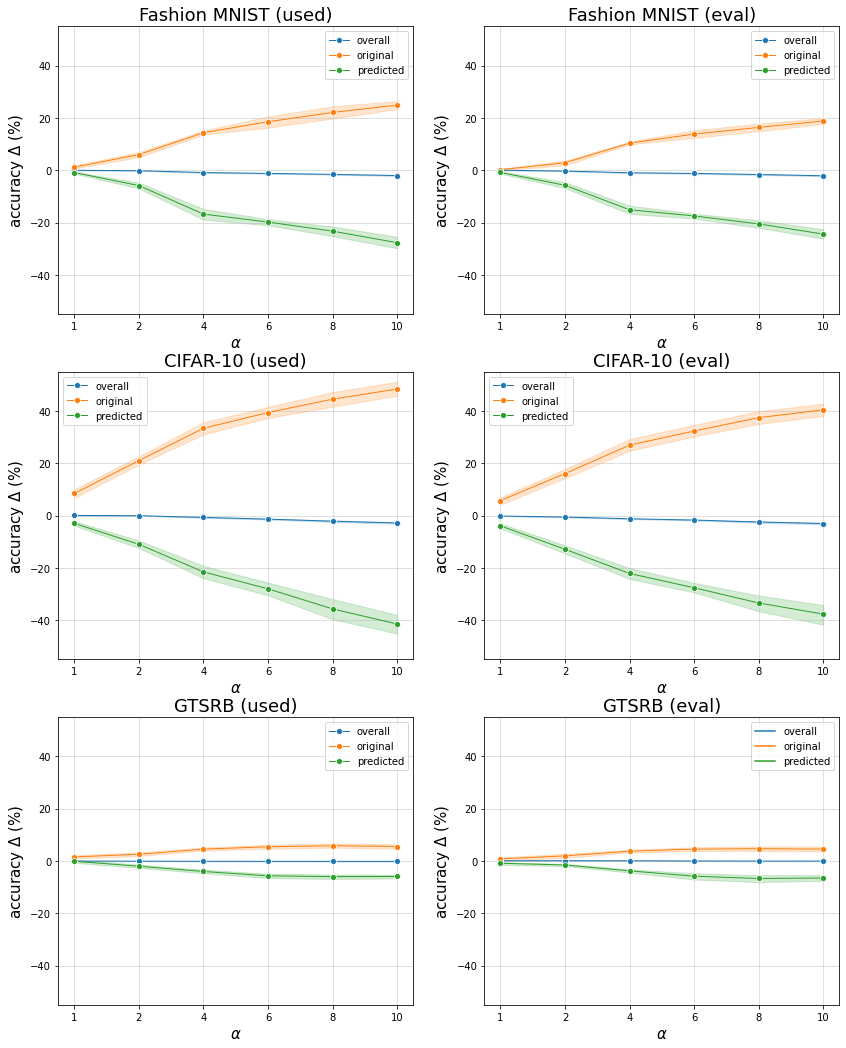

In [97]:
filepath = "/Users/jeongju.sohn/workdir/Journals/autopatch_nn_icse20/figures/rev/rq4/alpha_in_all.pdf"

plot_acc_chgs(combined_data, ['overall', 'original', 'predicted'], figsize = (14,18), filepath = filepath)

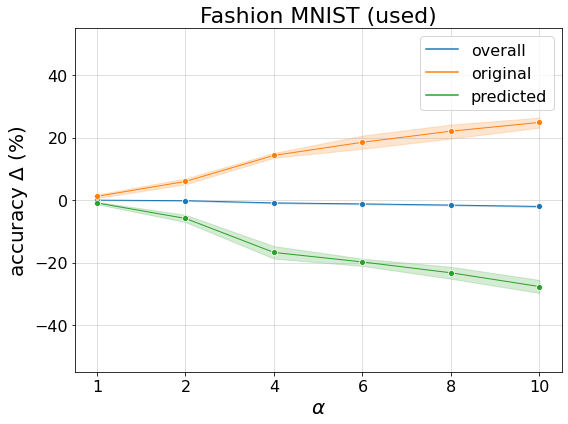

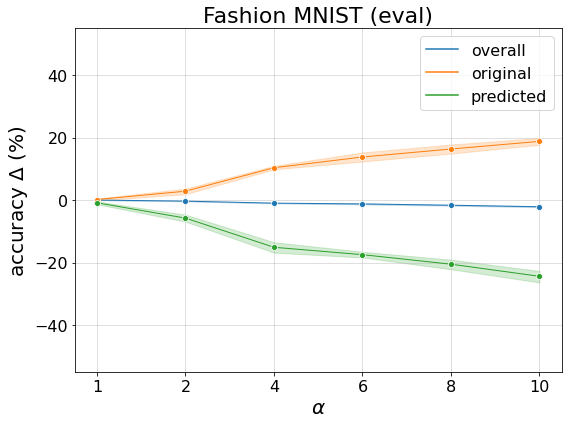

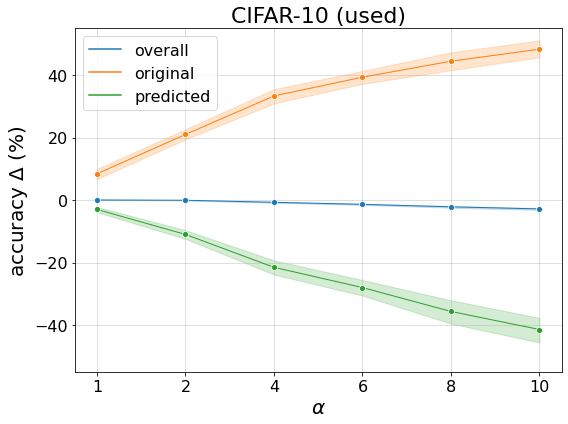

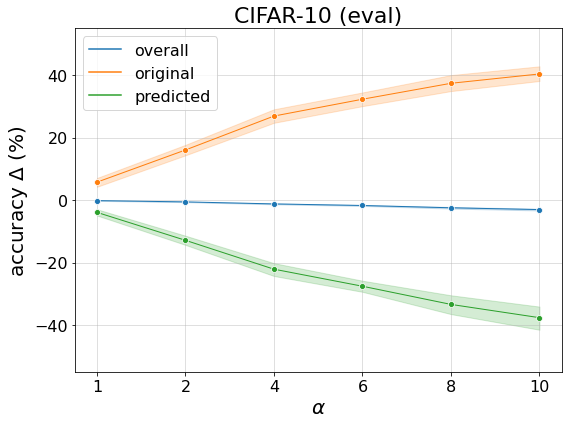

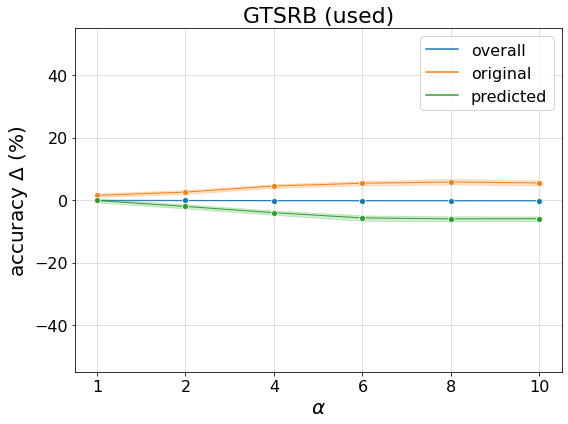

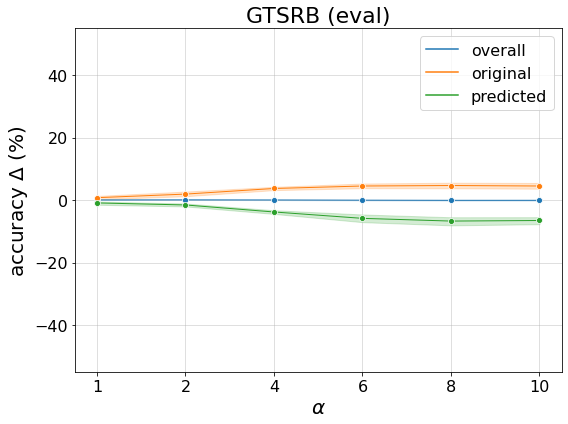

In [101]:
dest = "/Users/jeongju.sohn/workdir/Journals/autopatch_nn_icse20/figures/rev/rq4/"

filepaths = {}
for k in combined_data.keys():
    filepaths[k] = {}
    for usage in combined_data[k].keys():
        filepaths[k][usage] = os.path.join(dest, "{}_{}.pdf".format(k, usage)).replace("-", "_").replace(" " ,"_")

plot_acc_chgs_pdata(combined_data, ['overall', 'original', 'predicted'], figsize = (8,6), filepaths = filepaths)

In [117]:
df = combined_data['CIFAR-10']['eval']
print (df.loc[(df.alpha == '10') & (df.dtype == 'original')].acc.mean())
print (df.loc[(df.alpha == '10') & (df.dtype == 'predicted')].acc.mean())

print (df.loc[(df.alpha == '1') & (df.dtype == 'original')].acc.mean())
print (df.loc[(df.alpha == '1') & (df.dtype == 'predicted')].acc.mean())

40.411347517730505
-37.66064257028111
5.744680851063833
-3.925702811244976
